In [12]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from glob import glob
from pathlib import Path

figure_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/figures')

## Load the Data

In [13]:
seqs = glob('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset/seq*.txt')

df = None
for seq in seqs:
    with open(seq, 'r') as fp:
        data = [line.strip().split(' ') for line in fp.readlines()]
        
    temp = pd.DataFrame(data=data, columns=[
        'image_id', 
        'shaft_start_y', 
        'shaft_start_x', 
        'shaft_end_y', 
        'shaft_end_x',  
        'tip_1_y', 
        'tip_1_x',
        'tip_2_y', 
        'tip_2_x'
    ])
    temp = temp.set_index('image_id')
    
    if df is None:
        df = temp
    else:
        df = pd.concat([df, temp])
        
df = df.astype(float)

In [114]:
df.shape

(1181, 8)

## Display Images with Annotations

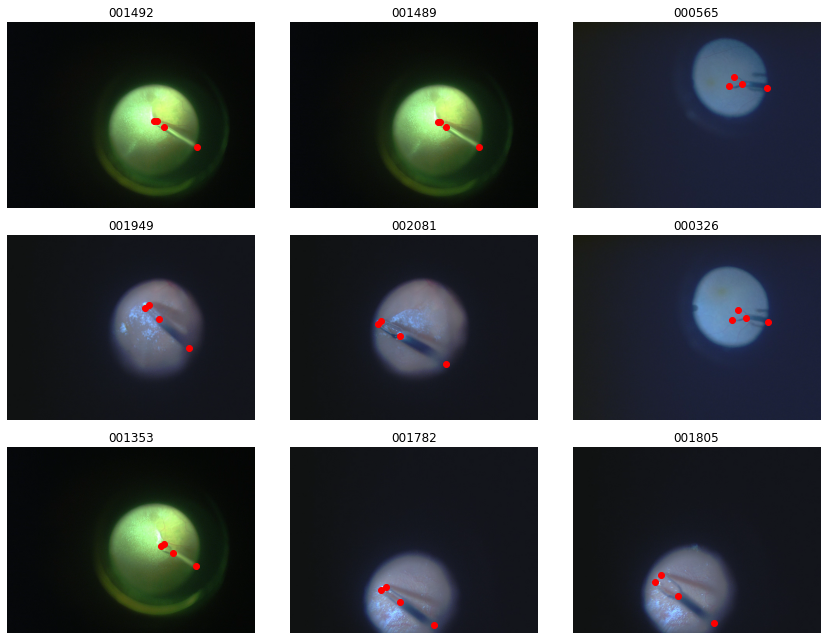

In [252]:


idx = pd.IndexSlice
image_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset')
rows = 3
cols = 3
sample_size = rows * cols
subplot_index = 1

plt.figure(figsize=(rows*4,cols*3))
for image_id, row in df.sample(sample_size).iterrows():
    img = plt.imread(image_folder / f'{image_id}.png')
    
    x = row[list(filter(lambda x: 'x' in x, df.columns))]
    y = row[list(filter(lambda x: 'y' in x, df.columns))]

    plt.subplot(rows, cols, subplot_index)
    plt.imshow(img)
    plt.scatter(
        x.values.astype(int),
        y.values.astype(int),
        c='red'
    )
    plt.axis('off')
    plt.title(image_id)
    subplot_index += 1
    
plt.tight_layout()
plt.savefig(figure_folder / '')

## Centering

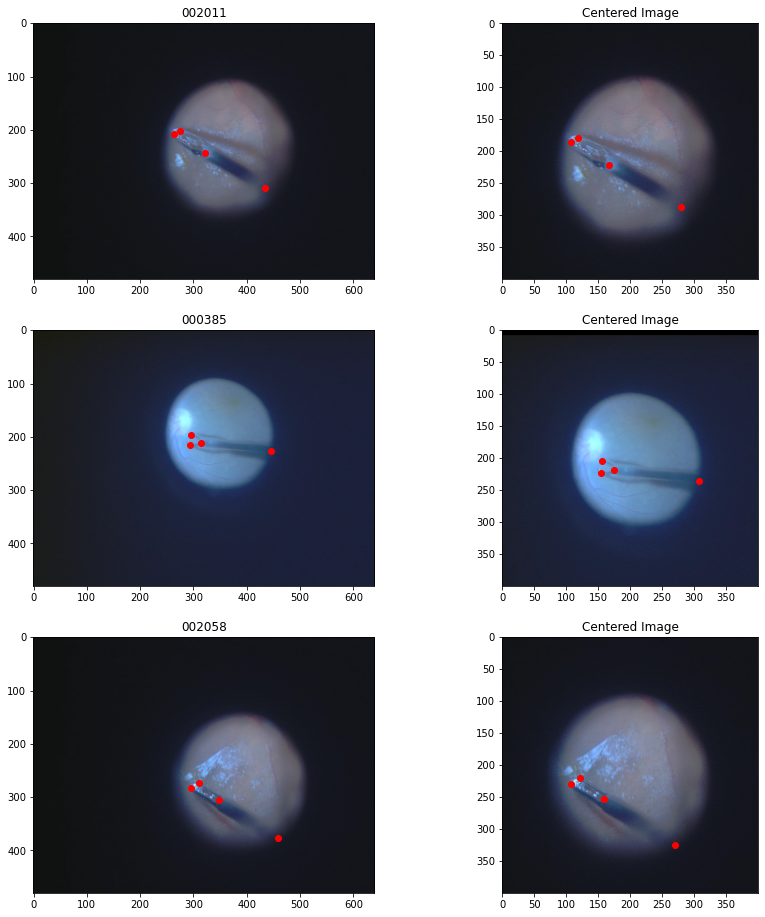

In [14]:
from skimage.transform import rescale

import numpy as np
from pathlib import Path

idx = pd.IndexSlice
image_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset')
sample_size = 3
subplot_index = 0
scale = 1/8
padding = 200

plt.figure(figsize=(14,16))
intensity_threshold = 0.3

def weighted_intensity_centering(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pixels_above_threshold = np.argwhere(gray > threshold)
    xx, yy = pixels_above_threshold.T
    pixel_intensities = gray[xx, yy]
    center_x = np.sum(xx @ pixel_intensities) / np.sum(pixel_intensities) 
    center_x = int(center_x)
    center_y = np.sum(yy @ pixel_intensities) / np.sum(pixel_intensities) 
    center_y = int(center_y)
    return center_x, center_y
    
for image_id, row in df.sample(sample_size).iterrows():
    plt.subplot(sample_size, 2, subplot_index*2+1)
    img = plt.imread(image_folder / f'{image_id}.png')    
    x = row[list(filter(lambda x: 'x' in x, df.columns))].values.astype(float)
    y = row[list(filter(lambda x: 'y' in x, df.columns))].values.astype(float)
    
    plt.imshow(img)
    plt.title(image_id)
    plt.scatter(x, y, c='red')
    
    # add padding to the x, y dimensions
    img = np.pad(img, pad_width=((padding, padding), (padding, padding), (0, 0)), constant_values=0)
    center_x, center_y = weighted_intensity_centering(img, intensity_threshold)
    
    centered_image = np.zeros((400, 400, 3))
    centered_image = img[center_x-padding:center_x+padding, center_y-padding:center_y+padding]
    
    plt.subplot(sample_size, 2, subplot_index*2+2)
    plt.title("Centered Image")
    
    plt.imshow(centered_image, cmap='gray')
    
    # there is a confusion over center_x and center_y values happening because
    # the x values in the data refer to the horizontal dimension, however in 
    # the image they refer to the first axis which is the vertical dim 
    x = (x + padding) - center_y + padding
    y = (y + padding) - center_x + padding
    plt.scatter(x, y, c='red')
    subplot_index += 1

## Show Rescaled Images and Data

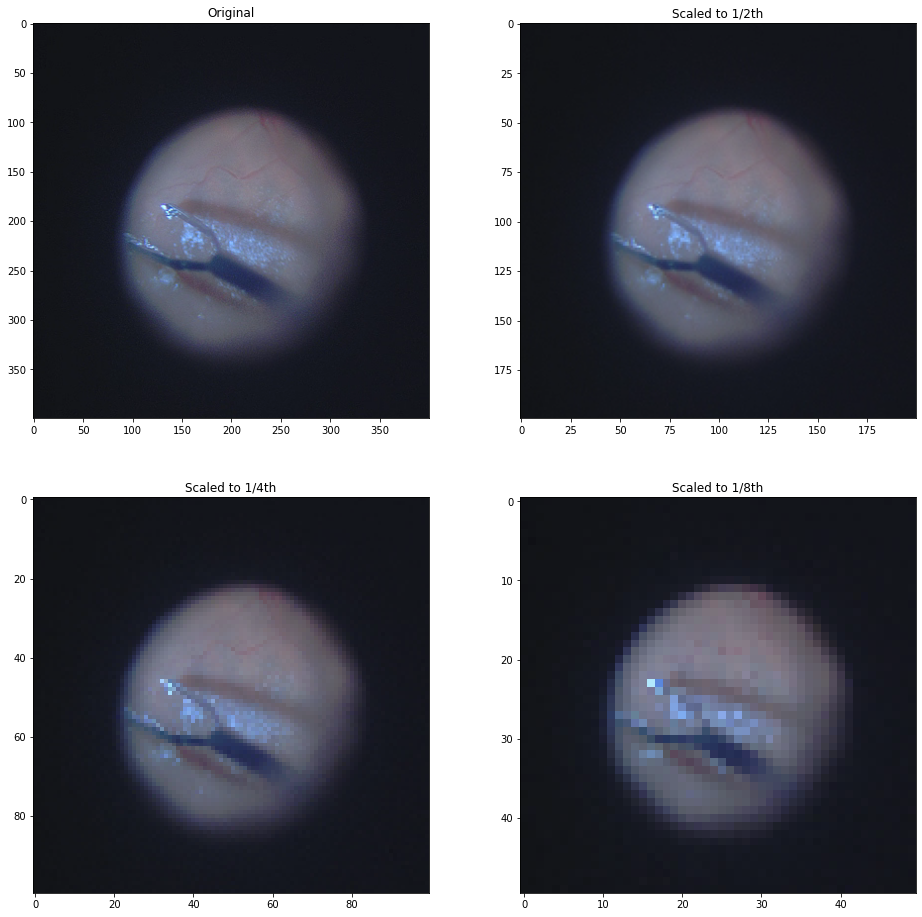

In [127]:
from skimage.transform import rescale

import numpy as np
from pathlib import Path

idx = pd.IndexSlice
image_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset')


sample_size = 1
subplot_index = 0
scale = 1/4

plt.figure(figsize=(16,16))
scales = [1, 1/2, 1/4, 1/8]
for image_id, row in df.sample(sample_size).iterrows():
    for subplot_index, scale in enumerate(scales):
        plt.subplot(2, 2, subplot_index+1)
        img = plt.imread(image_folder / f'{image_id}.png')
        x = row[list(filter(lambda x: 'x' in x, df.columns))].values.astype(float)
        y = row[list(filter(lambda x: 'y' in x, df.columns))].values.astype(float)

        img = np.pad(img, pad_width=((padding, padding), (padding, padding), (0, 0)), constant_values=0)
        center_x, center_y = weighted_intensity_centering(img, intensity_threshold)

        centered_image = np.zeros((400, 400, 3))
        img = img[center_x-padding:center_x+padding, center_y-padding:center_y+padding]

#         plt.imshow(img)
    #     plt.scatter(x, y, c='red')
    #     plt.axis('off')
#         plt.title(f'{image_id}.png')

#         plt.subplot(2, 2, subplot_index)
        image_rescaled = rescale(img, scale, anti_aliasing=False, multichannel=True)
#         image_rescaled = rescale(image_rescaled, 1/scale, anti_aliasing=False, multichannel=True)
        plt.imshow(image_rescaled, cmap='gray')
        frac = scale.as_integer_ratio()
        
        if scale == 1:
            plt.title('Original')
        else:
            plt.title(f"Scaled to {frac[0]}/{frac[1]}th")
    #     plt.scatter(x*scale, y*scale, c='red')
    #     plt.axis('off')

        subplot_index += 1
    
plt.savefig(figure_folder / 'downscaled.png')

# Create Centered dataset

In [19]:
import os
import shutil
from PIL import Image

image_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset')
centered_folder = (image_folder / '../centered/').resolve()

if os.path.exists(centered_folder):
    shutil.rmtree(centered_folder)
os.makedirs(centered_folder)

padding = 200

intensity_threshold = 0.3
x_columns = list(filter(lambda x: 'x' in x, df.columns))
y_columns = list(filter(lambda x: 'y' in x, df.columns))

centered_df = df.copy()
for image_id, row in df.iterrows():
    if not os.path.exists(image_folder / f'{image_id}.png'):
        centered_df = centered_df.drop(image_id)
        continue 
        
    img = Image.open(image_folder / f'{image_id}.png')   
    img = np.array(img)
    
    # add padding to the x, y dimensions
    img = np.pad(img, pad_width=((padding, padding), (padding, padding), (0, 0)), constant_values=0)
    center_x, center_y = weighted_intensity_centering(img, intensity_threshold)
    
    centered_image = np.zeros((400, 400, 3))
    centered_image = img[center_x-padding:center_x+padding, center_y-padding:center_y+padding]
    
    # there is a confusion over center_x and center_y values happening because
    # the x values in the data refer to the horizontal dimension, however in 
    # the image they refer to the first axis which is the vertical dim 
    centered_df.loc[image_id, x_columns] += 2*padding - center_y
    centered_df.loc[image_id, y_columns] += 2*padding - center_x
    
    # validate all values are within range 
    values = centered_df.loc[image_id].values 
    in_range = (values > 0).all() & (values < 2*padding).all()
    if not in_range:
        centered_df = centered_df.drop(image_id)
        continue 
        
    # Save the image - FIX this (outputs alpha channel)
    im = Image.fromarray(centered_image)
    im.save(centered_folder / f'{image_id}.png')
    
centered_df.to_csv(centered_folder / 'annotations.csv')

## Create Scaled Datasets

In [308]:
%%time
padding = 200
x_columns = list(filter(lambda x: 'x' in x, df.columns))
y_columns = list(filter(lambda x: 'y' in x, df.columns))

image_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/retinal_dataset')
for scale in [1/4, 1/8]:
    frac = scale.as_integer_ratio()
    print(f'working on scale {frac[0]}/{frac[1]}')
    
    scaled_folder = image_folder / f'../centered_scale-{frac[0]}-over-{frac[1]}'
    scaled_folder = scaled_folder.resolve()

    rescaled_folder = image_folder / f'../centered_rescaled-from-{frac[0]}-over-{frac[1]}'
    rescaled_folder = rescaled_folder.resolve()
    
    if os.path.exists(scaled_folder):
        shutil.rmtree(scaled_folder)
    os.makedirs(scaled_folder)
    
    if os.path.exists(rescaled_folder):
        shutil.rmtree(rescaled_folder)
    os.makedirs(rescaled_folder)
    
    scaled_df = centered_df.copy()
    for image_id, row in centered_df.iterrows():
        if not os.path.exists(centered_folder / f'{image_id}.png'):
            centered_df = centered_df.drop(image_id)
            continue

        img = Image.open(centered_folder / f'{image_id}.png')
        
        scaled = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), resample=Image.BICUBIC)
        scaled.save(scaled_folder / f'{image_id}.png')
        
        rescaled = scaled.resize(img.size, resample=Image.BILINEAR)
        rescaled.save(rescaled_folder / f'{image_id}.png')
        
        # there is a confusion over center_x and center_y values happening because
        # the x values in the data refer to the horizontal dimension, however in 
        # the image they refer to the first axis which is the vertical dim 
        scaled_df.loc[image_id, x_columns] *= scale
        scaled_df.loc[image_id, y_columns] *= scale

    scaled_df.to_csv(scaled_folder / 'annotations.csv')

working on scale 1/4
working on scale 1/8
Wall time: 2min 29s


## Validate Scaled Images

In [16]:
scaled_df

,shaft_start_y,shaft_start_x,shaft_end_y,shaft_end_x,tip_1_y,tip_1_x,tip_2_y,tip_2_x
image_id,,,,,,,,
224,30.500,37.750,28.375,28.750,24.625,25.625,29.500,23.500
225,30.375,37.875,28.375,29.125,24.875,25.875,29.500,23.875
226,30.500,37.750,28.000,28.875,24.500,25.875,29.250,23.875
227,30.250,38.000,28.125,28.625,25.000,25.500,29.250,24.000
228,30.125,38.125,28.000,28.625,25.625,25.750,28.625,24.500
...,...,...,...,...,...,...,...,...
2093,40.750,32.250,32.250,17.875,28.375,13.250,29.375,12.000
2094,40.250,32.375,32.000,18.375,28.250,13.500,29.250,12.250
2095,40.375,33.500,32.250,18.500,28.250,13.250,29.125,12.375


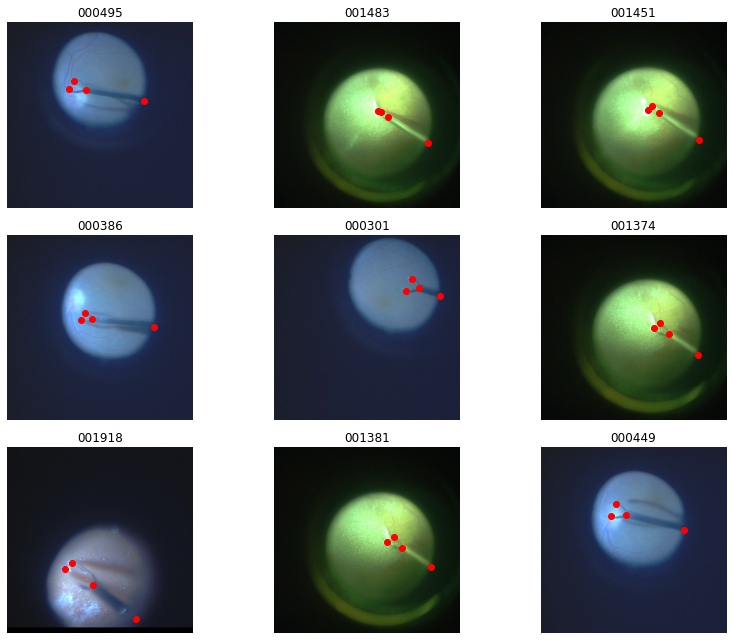

In [354]:
idx = pd.IndexSlice
scaled_folder = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/centered')
scaled_df = pd.read_csv(scaled_folder / 'annotations.csv')
scaled_df.image_id = scaled_df.image_id.astype(str).apply(lambda x: x.zfill(6))
scaled_df = scaled_df.set_index('image_id')

rows = 3
cols = 3
sample_size = rows * cols
subplot_index = 1

plt.figure(figsize=(rows*4,cols*3))
for image_id, row in scaled_df.sample(sample_size).iterrows():
    img = plt.imread(scaled_folder / f'{image_id}.png')
    
    x = row[list(filter(lambda x: 'x' in x, df.columns))]
    y = row[list(filter(lambda x: 'y' in x, df.columns))]

    plt.subplot(rows, cols, subplot_index)
    plt.imshow(img)
    plt.scatter(
        x.values.astype(int),
        y.values.astype(int),
        c='red'
    )
    plt.axis('off')
    plt.title(image_id)
    subplot_index += 1
    
plt.tight_layout()

# Create Validation/Training Splits

In [337]:
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np

data_root = Path('C:/Users/Owner/Documents/repos/COMP5900F/project/retinal_dataset/')

scale_folders = glob(str(data_root / 'centered*'))

df = pd.read_csv(scale_folders[0] + '\\annotations.csv')
image_ids = np.array([str(image_id).zfill(6) for image_id in df.image_id.values])

indices = np.arange(image_ids.shape[0])
np.random.shuffle(indices)

# split = int(0.7 * indices.shape[0])
split = 50

train_indices = indices[:split]
test_indices = indices[split:]

train_ids = image_ids[train_indices]
test_ids = image_ids[test_indices]

postfix = '-xxs'
np.savetxt(data_root / f'train_ids{postfix}.txt', train_ids, fmt='%s')
np.savetxt(data_root / f'test_ids{postfix}.txt', test_ids, fmt='%s')

In [75]:
%%time
import os 
import shutil

postfix = '-xxs'
train_ids = np.genfromtxt(data_root / f'train_ids{postfix}.txt', dtype=str)
validate_ids = np.genfromtxt(data_root / f'validate_ids{postfix}.txt', dtype=str)
test_ids = np.genfromtxt(data_root / f'test_ids{postfix}.txt', dtype=str)

scale_folders = glob(str(data_root / 'centered*'))
for folder in scale_folders:
    print(folder)
    train_folder = folder + '/train'
    validate_folder = folder + '/validate'
    test_folder = folder + '/test'
    
    for subfolder in [train_folder, validate_folder, test_folder]:
        if os.path.exists(subfolder):
            shutil.rmtree(subfolder)
        os.mkdir(subfolder)
    
    for image_file in glob(folder + '/*.png'):
        image_id = os.path.splitext(os.path.split(image_file)[1])[0]

        if image_id in train_ids:
            shutil.copy(image_file, train_folder)
        elif image_id in test_ids:
            shutil.copy(image_file, test_folder)

C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_rescaled-from-1-over-16
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_rescaled-from-1-over-2
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_rescaled-from-1-over-4
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_rescaled-from-1-over-8
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_scale-1-over-16
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_scale-1-over-2
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_scale-1-over-4
C:\Users\Owner\Documents\repos\COMP5900F\project\retinal_dataset\centered_scale-1-over-8
Wall time: 1min 26s


In [344]:
postfix = ''
train_ids = np.genfromtxt(data_root / f'train_ids{postfix}.txt', dtype=str)
test_ids = np.genfromtxt(data_root / f'test_ids{postfix}.txt', dtype=str)

In [350]:
postfix = '-xxs'
train_ids = np.genfromtxt(data_root / f'train_ids{postfix}.txt', dtype=str)
test_ids = np.genfromtxt(data_root / f'test_ids{postfix}.txt', dtype=str)

# Create Deepercut Pose Estimation

In [351]:
# focus = 'centered-rescaled-1-over-4'
# focus = 'centered'
focus = 'centered-scale-1-over-8'

annotations = pd.read_csv('retinal_dataset/centered_scale-1-over-8/annotations.csv', dtype={'image_id': str}) # ! THIS SHOULD NOT CHANGE
image_folder = f'/data/retinal_dataset/{focus}'

data = []
for idx, row in annotations.iterrows():
    if row.image_id in test_ids: continue
    
    image_file = f'{image_folder}/{row.image_id}.png'
    image_file = np.array([image_file])
    size = np.array([[3, 400, 400]], dtype=np.uint16)
    
    joints = []
    for joint_id, joint in enumerate(['shaft_start', 'shaft_end', 'tip_1', 'tip_2']):
        joints.append([joint_id, row[joint + '_x'], row[joint + '_y']])
    joints = [[np.array(joints, '<i4')]]
    
    struct_array = np.array(
        object=(image_file, size, joints),
        dtype=[('image', 'O'), ('size', 'O'), ('joints', 'O')]
    )
    
    data.append(struct_array)
    
data = np.array([data])
scipy.io.savemat(f'retinal_dataset/dataset-{focus}{postfix}.mat', {'dataset': data})

In [352]:
len(data[0])

50

In [340]:
test = scipy.io.loadmat(f'retinal_dataset/dataset-{focus}-xxs.mat')
len(test['dataset'][0])

50